# Classificação de Textos do HuffPost utilizando diferentes algoritmos de Machine Learning.

### Adiciona imports necessários carrega em memória a base no formato JSON e adiciona a um DataFrame da biblioteca pandas

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
import json

import spacy
from spacy.tokens import Doc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

#for model assessment
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import pickle

# from sklearn.model_selection import ValidationCurveDisplay,validation_curve

metrics_dataframe = pd.DataFrame(columns=['f1-score', 'precision-score', 'accuracy-score'],
                                 index=['nearestcentroid', 'knn', 'svm', 'naivebayes', 'nn'], data=0.)

print(metrics_dataframe)


# spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")


path = "work/News_Category_Dataset_v3.json"

# Read JSON file line by line
data = []
with open(path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert the list of dictionaries to a DataFrame
dataframe = pd.DataFrame(data)

# Print the DataFrame
dataframe


                 f1-score  precision-score  accuracy-score
nearestcentroid       0.0              0.0             0.0
knn                   0.0              0.0             0.0
svm                   0.0              0.0             0.0
naivebayes            0.0              0.0             0.0
nn                    0.0              0.0             0.0


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


## Realizar uma análise descritiva dos dados, com foco na descoberta de dados em branco nos campos alvo da análise (short description e headline)
### Cria também uma função para remover linha vazia do DataFrame e por fim checa se a remoção foi efetiva.

In [2]:
#dataframe.describe()
describe = dataframe.describe()
print(describe)

describe.loc['top']

#show the empty lines in the [headline] column
dataframe.loc[dataframe["headline"] == ""]


#show the empty lines in the [short_description] column
dataframe.loc[dataframe["short_description"] == "",]


def removeEmptyLine(df,col_name):
    df.replace("", pd.NA, inplace = True)
    df.dropna(subset=[col_name], inplace=True)
    return df


dataframe = removeEmptyLine(dataframe,"headline")
dataframe = removeEmptyLine(dataframe,"short_description")


print((dataframe["headline"] == "").sum())
print((dataframe["short_description"] == "").sum())


                                                     link        headline  \
count                                              209527          209527   
unique                                             209486          207996   
top     https://www.huffingtonpost.comhttps://www.wash...  Sunday Roundup   
freq                                                    2              90   

        category short_description authors        date  
count     209527            209527  209527      209527  
unique        42            187022   29169        3890  
top     POLITICS                            2014-03-25  
freq       35602             19712   37418         100  
0
0


## Agrupa em um DataFrame a contagem das categorias por títulos

### Com isso temos a visão de quais categorias são mais frequentes em publicações no HuffPost

### Também são selecionadas as categorias que possuem mais de 4000 postagens para só processarmos os dados mais relevantes da amostra

           headline
count     42.000000
mean    4519.380952
std     5715.053524
min      863.000000
25%     1473.250000
50%     2959.000000
75%     4585.000000
max    32441.000000
863


['POLITICS',
 'WELLNESS',
 'ENTERTAINMENT',
 'STYLE & BEAUTY',
 'TRAVEL',
 'PARENTING',
 'FOOD & DRINK',
 'QUEER VOICES',
 'HEALTHY LIVING',
 'BUSINESS',
 'COMEDY',
 'SPORTS',
 'HOME & LIVING',
 'BLACK VOICES']

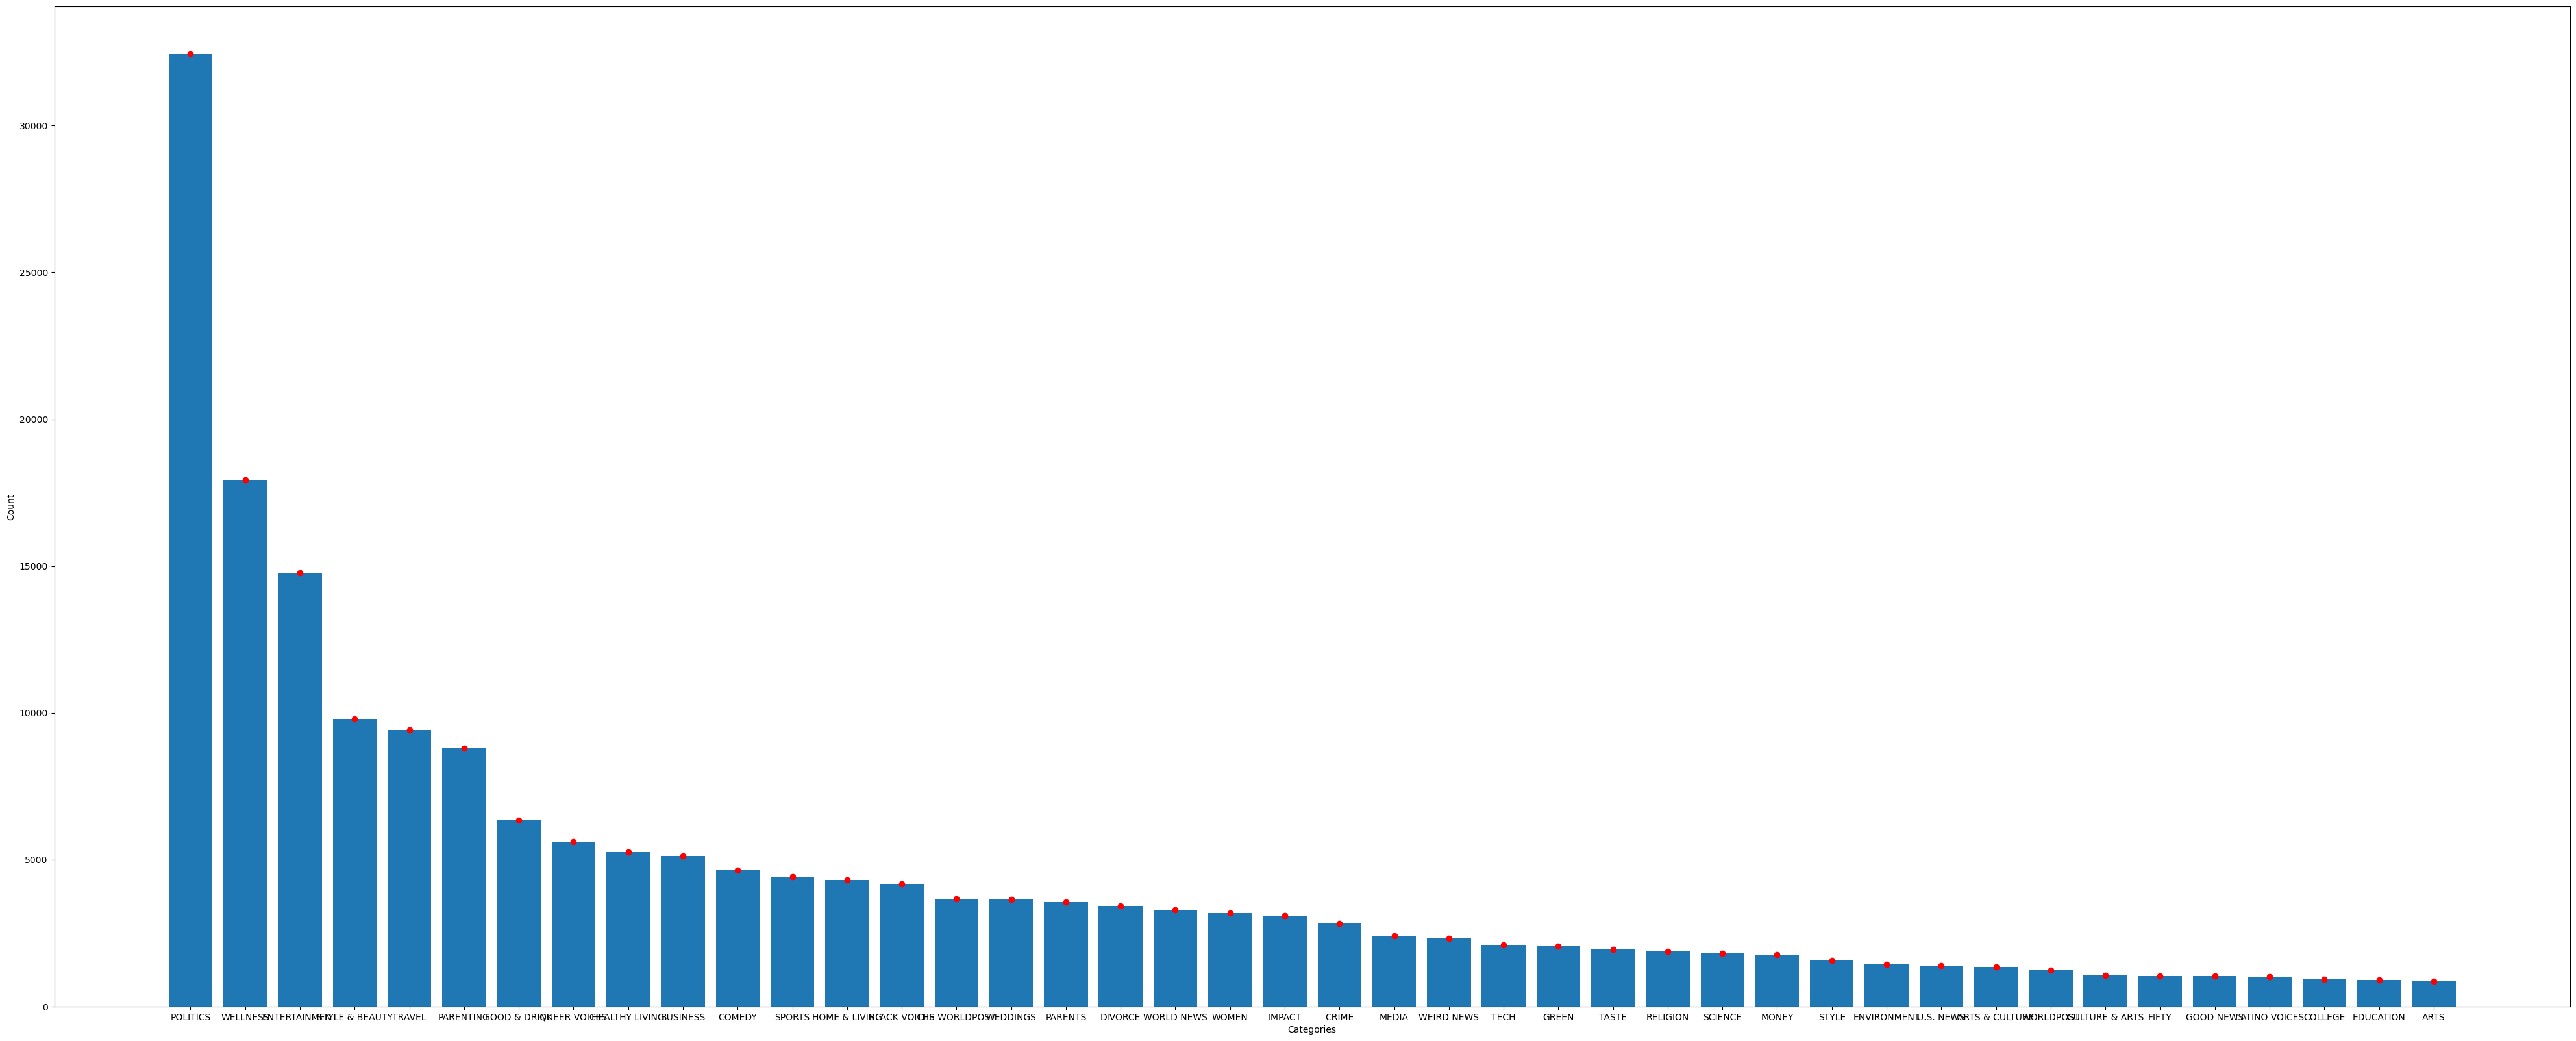

In [18]:
count_df = pd.DataFrame(dataframe.groupby(["category"]).count()["headline"].sort_values(ascending=False),columns=["headline"])
print(count_df.describe())
print(dataframe.groupby(["category"]).count()["headline"].min())
plt.figure(figsize=(50,20))
plt.xlabel("Categories")
plt.ylabel("Count")
plt.bar(count_df.index,count_df["headline"])
plt.plot(count_df.index,count_df["headline"],'ro')


#get the category with number of news more than 4000
category_list = count_df.loc[count_df["headline"] >= 4000].index.to_list()
category_list



## Seleção das primeiras mil categorias e adicionamos a um novo DataFrame

In [4]:
# category_list = [
#     'POLITICS',
#     'WELLNESS',
#     'ENTERTAINMENT',
#     'TRAVEL',
#     'STYLE & BEAUTY',
#     'PARENTING',
#     'HEALTHY LIVING',
#     'QUEER VOICES',
#     'FOOD & DRINK',
#     'BUSINESS',
#     'COMEDY',
#     'SPORTS',
#     'HOME & LIVING',
#     'BLACK VOICES'
# ]

my_list = []
for cat in category_list:
    my_list.append(dataframe.loc[dataframe["category"] == cat,['headline','category','short_description']].head(1000))
df = pd.concat(my_list, ignore_index=True)
df["full_new"] = df["headline"] +' '+ df["short_description"]
df

,headline,category,short_description,full_new
0,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,Biden Says U.S. Forces Would Defend Taiwan If ...
1,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,‘Beautiful And Sad At The Same Time’: Ukrainia...
2,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS,"U.S. President Joe Biden, in London for the fu...",Biden Says Queen's Death Left 'Giant Hole' For...
3,Bill To Help Afghans Who Escaped Taliban Faces...,POLITICS,Republican outrage over the shoddy U.S. withdr...,Bill To Help Afghans Who Escaped Taliban Faces...
4,Mark Meadows Complies With Justice Dept. Subpo...,POLITICS,The former White House chief of staff has turn...,Mark Meadows Complies With Justice Dept. Subpo...
...,...,...,...,...
13995,Timid Reporting On Racism Skews Our Political ...,BLACK VOICES,The truth behind “economic populism” and “iden...,Timid Reporting On Racism Skews Our Political ...
13996,"'Everything, Everything' Answers Calls For Mor...",BLACK VOICES,"Even in 2017, the market for films with women ...","'Everything, Everything' Answers Calls For Mor..."
13997,New Orleans Principal Fired After Video Captur...,BLACK VOICES,He was already being investigated after photos...,New Orleans Principal Fired After Video Captur...
13998,How Moonlight Muted Me,BLACK VOICES,I saw Moonlight for the first time at the begi...,How Moonlight Muted Me I saw Moonlight for the...


## Para fins de visualização de resultado temos as categorias selecionadas para o processamento

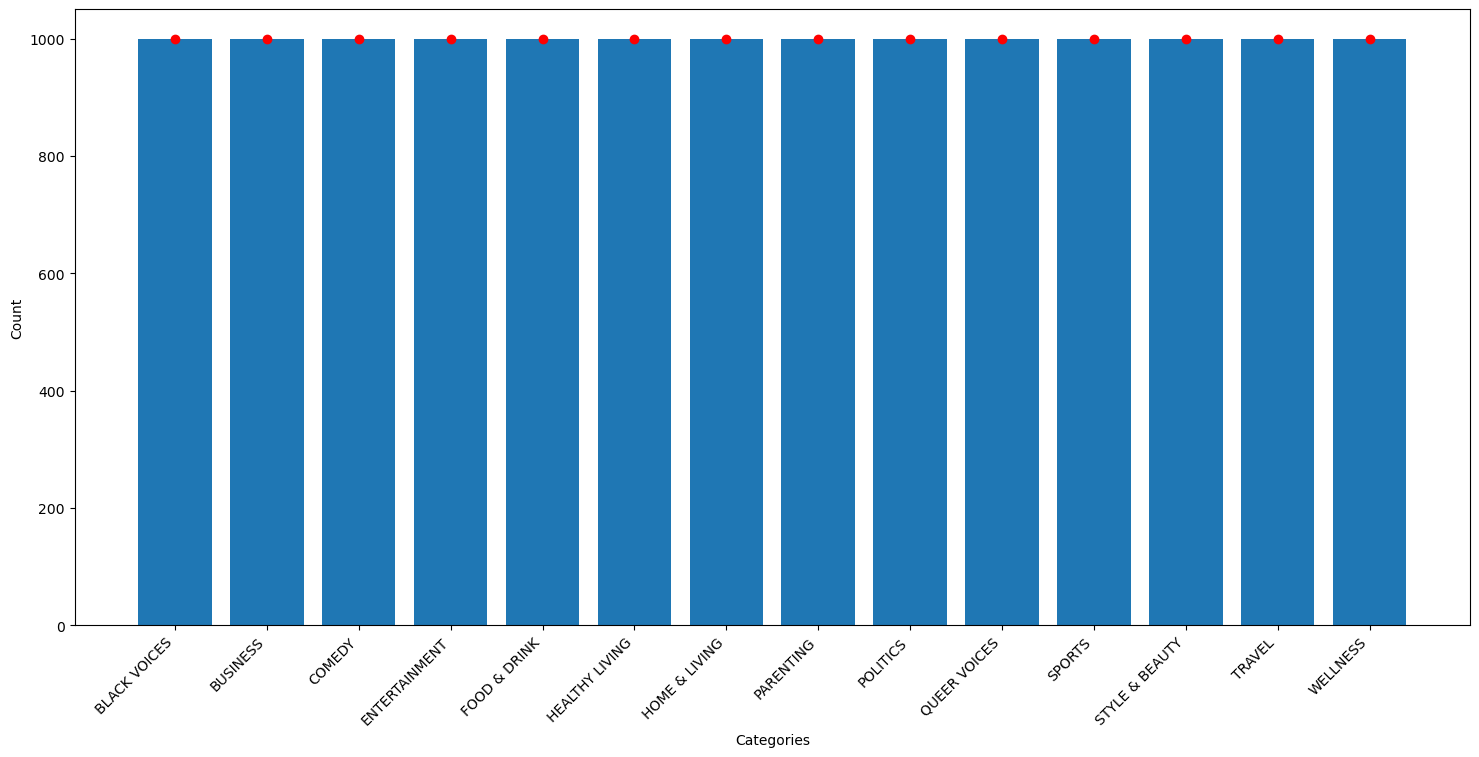

In [5]:

count_df = pd.DataFrame(df.groupby(["category"]).count()["full_new"].sort_values(ascending=False))

plt.figure(figsize=(18,8))
plt.xlabel("Categories")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.bar(count_df.index,count_df["full_new"])
plt.plot(count_df.index,count_df["full_new"],'ro')


## Cria-se a funcão de remoção de linha vazia e pré-processamento (remoção de números, pontos, stopwords)

In [6]:
def removeEmptyRow(df,col_name):
    df.replace([" ","","_","__"], pd.NA, inplace = True)
    df.dropna(subset=[col_name], inplace=True)
    return df


df = removeEmptyRow(df,"full_new")
df.head()



def text_preprocessing(df,col_name):
    all_doc = []
    for index,row in df.iterrows():
        doc = nlp(row[col_name])
        token_text = []
        for token in doc:
            if not(token.like_num or token.is_punct or token.is_stop):
                token_text.append(str(token.lemma_).lower())
        token_text = " ".join(token_text)
        all_doc.append(token_text)
    df.loc[:,col_name] = all_doc
    return df

## Aqui é criada a função de TFIDF que consiste em transformar os termos em número de ocorrências relativas ao número de ocorrências inversamente proporcionais a quantidade de aparições em textos de outros assuntos.

### Adiciona também a função para criar a matriz de confusão

In [7]:
def tfIdf(df,col_name,target_col_name):
    vectorizer = TfidfVectorizer()
    feature = vectorizer.fit_transform(df.loc[:,col_name])
    tdf_df = pd.DataFrame(feature.toarray(),columns=vectorizer.get_feature_names_out())
    X_train, X_test , y_train, y_test = train_test_split(feature.toarray(),df.loc[:,target_col_name],random_state = 42)
    return X_train, X_test,y_train,y_test



def confused_matrix(y_test, y_pred,labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred,labels = labels)

    # Display the confusion matrix
    plt.figure(figsize=(10, 10))  # Sets the figure size
    sns.heatmap(cm, annot=True, fmt="d",xticklabels = labels,yticklabels = labels,)  # Plots the confusion matrix as a heatmap
    plt.title('Confusion matrix')  # Sets the title of the plot
    plt.ylabel('Actual label')  # Sets the label of the y-axis
    plt.xlabel('Predicted label')  # Sets the label of the x-axis
    plt.show()  # Displays the plot


X_train, X_test,y_train,y_test = tfIdf(df,'full_new','category')


### Aqui começa a invocação das funções dos algoritmos de IA o primeiro é o NearestCentroid.
### Adicionei um DataFrame para colher os resultados para gerar um gráfico comparativo com as métricas f1-score, precision-score e accuracy-score para cada algoritmo

                 f1-score  precision-score  accuracy-score
nearestcentroid   0.62184          0.64713        0.613429
knn               0.00000          0.00000        0.000000
svm               0.00000          0.00000        0.000000
naivebayes        0.00000          0.00000        0.000000
nn                0.00000          0.00000        0.000000


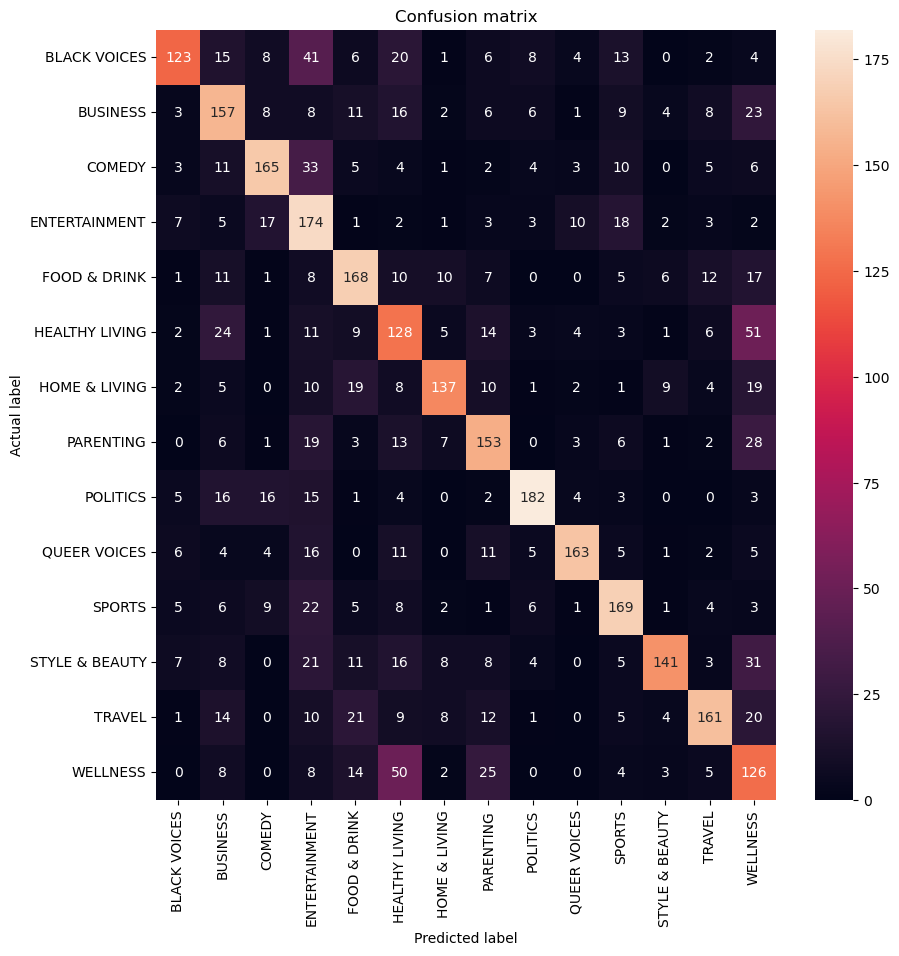

In [8]:

from sklearn.neighbors import NearestCentroid

def nearestCentroidAlgo(X_train, X_test,y_train,y_test, mdf):
    knn = NearestCentroid()
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mdf.loc['nearestcentroid'] = [f1_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)]
    print(mdf)
    confused_matrix(y_test, y_pred,knn.classes_)

nearestCentroidAlgo(X_train, X_test,y_train,y_test, metrics_dataframe)


### Aqui invoco o algoritmo KNN com algoritmo KD Tree com tamanho de nó 200. 

                 f1-score  precision-score  accuracy-score
nearestcentroid   0.62184         0.647130        0.613429
knn               0.63082         0.648144        0.628286
svm               0.00000         0.000000        0.000000
naivebayes        0.00000         0.000000        0.000000
nn                0.00000         0.000000        0.000000


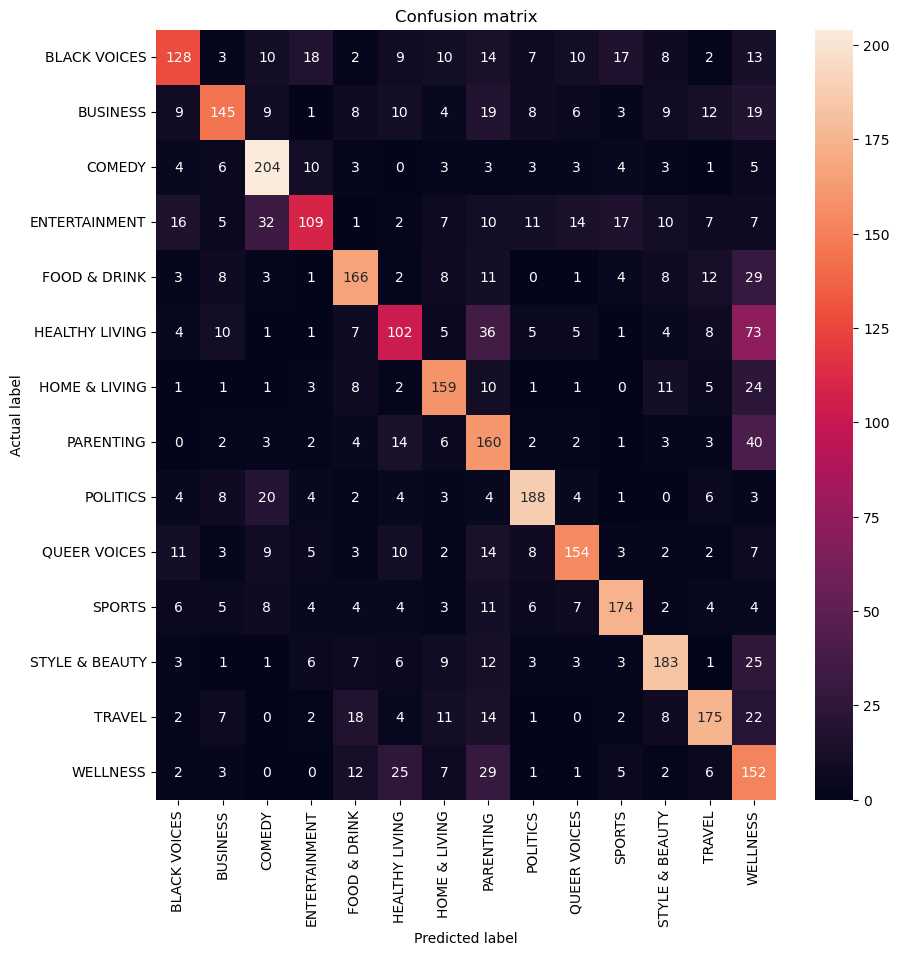

In [9]:
from sklearn.neighbors import KNeighborsClassifier

def knnAlogo(X_train, X_test,y_train,y_test, mdf):
    neigh = KNeighborsClassifier(algorithm='kd_tree', leaf_size=200, n_neighbors=25,weights='distance')
    neigh = neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    mdf.loc['knn'] = [f1_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)]
    print(mdf)
    confused_matrix(y_test, y_pred,neigh.classes_)


knnAlogo(X_train, X_test,y_train,y_test, metrics_dataframe)

### Aqui invoco o algoritmo SVM 

                 f1-score  precision-score  accuracy-score
nearestcentroid  0.621840         0.647130        0.613429
knn              0.630820         0.648144        0.628286
svm              0.711134         0.717400        0.707143
naivebayes       0.000000         0.000000        0.000000
nn               0.000000         0.000000        0.000000


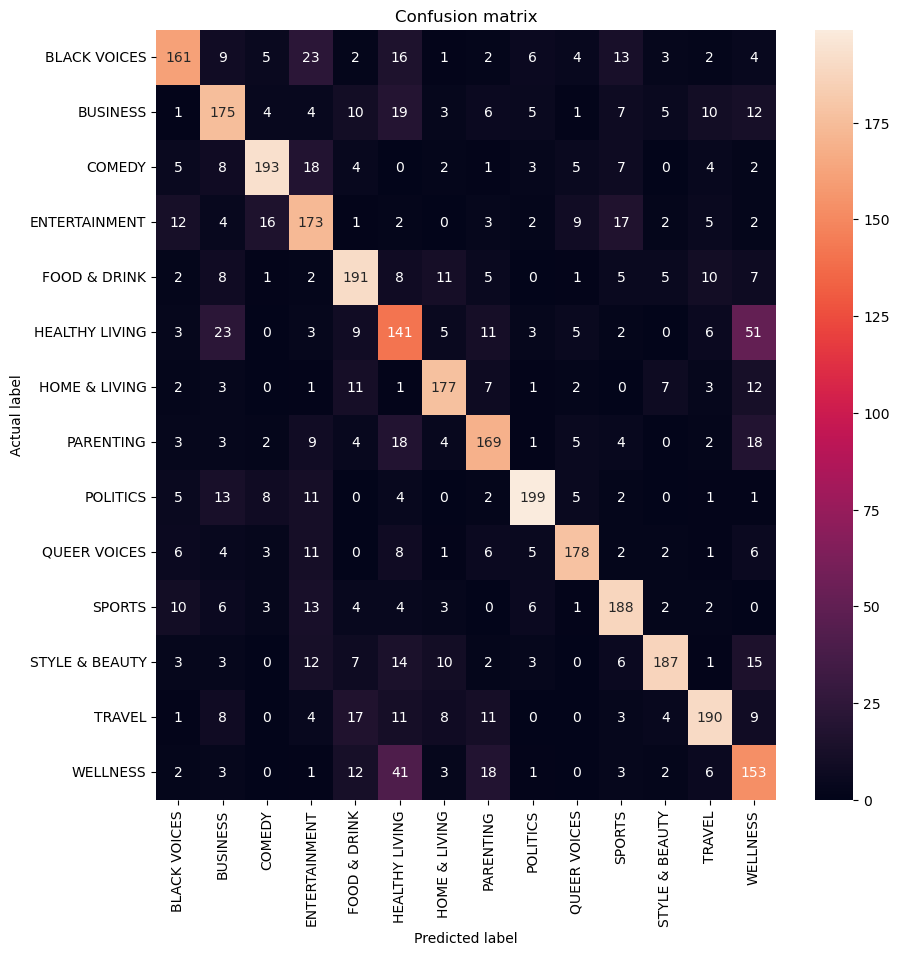

In [10]:
def svmAlgo(X_train, X_test,y_train,y_test, mdf):
    # Define the SVM classifier
    svm_classifier = svm.SVC(C = 5,kernel = 'rbf',gamma='scale',probability=True)
    svm_cv = svm_classifier
    svm_cv = svm_cv.fit(X_train, y_train)
    # Evaluate the best model on the test set
    y_pred = svm_cv.predict(X_test)
    mdf.loc['svm'] = [f1_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)]
    print(mdf)
    confused_matrix(y_test, y_pred,svm_cv.classes_)


svmAlgo(X_train, X_test,y_train,y_test, metrics_dataframe)

### Invocação do algoritmo Naive Bayes

                 f1-score  precision-score  accuracy-score
nearestcentroid  0.621840         0.647130        0.613429
knn              0.630820         0.648144        0.628286
svm              0.711134         0.717400        0.707143
naivebayes       0.481655         0.488816        0.481143
nn               0.000000         0.000000        0.000000


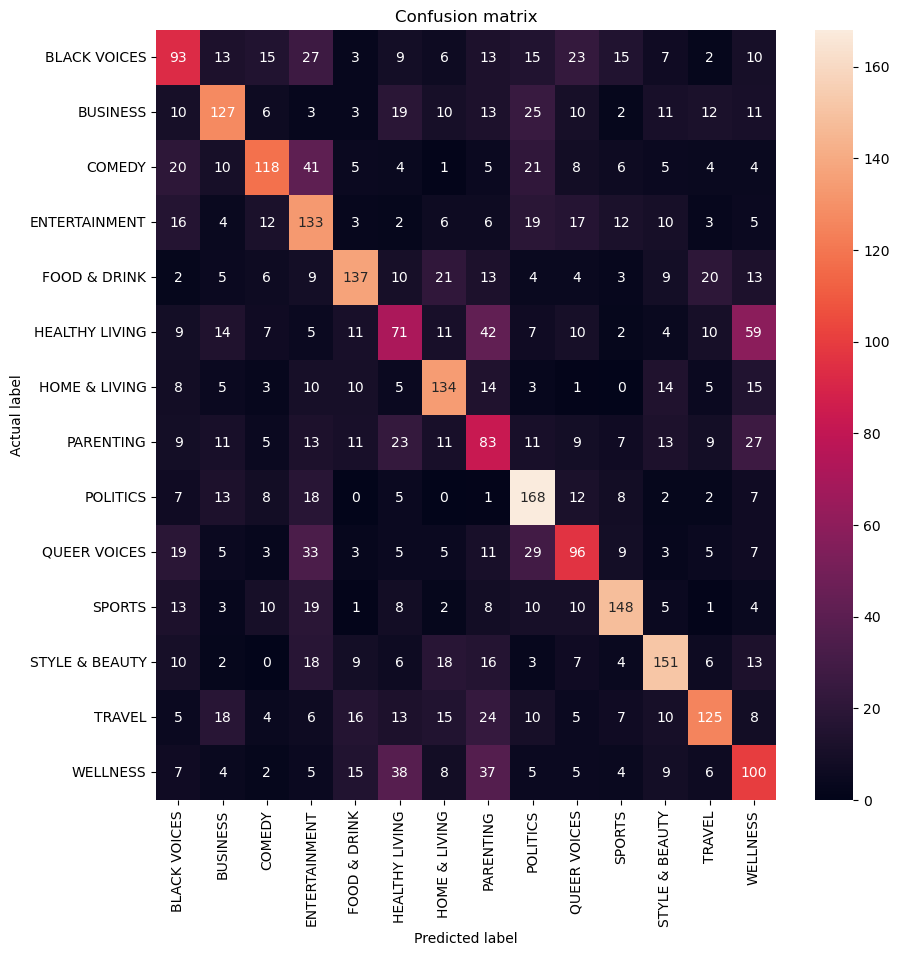

In [11]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes(X_train, X_test,y_train,y_test, mdf):
    model = GaussianNB()
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mdf.loc['naivebayes'] = [f1_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)]
    print(mdf)
    confused_matrix(y_test, y_pred, model.classes_)

naive_bayes(X_train, X_test, y_train, y_test, metrics_dataframe)

### Por fim a invocação do algoritmo de Neural Network com 150 hidden layers usando relu como função de ativação e 200 de iteração máxima.

                 f1-score  precision-score  accuracy-score
nearestcentroid  0.621840         0.647130        0.613429
knn              0.630820         0.648144        0.628286
svm              0.711134         0.717400        0.707143
naivebayes       0.481655         0.488816        0.481143
nn               0.707445         0.708638        0.706286


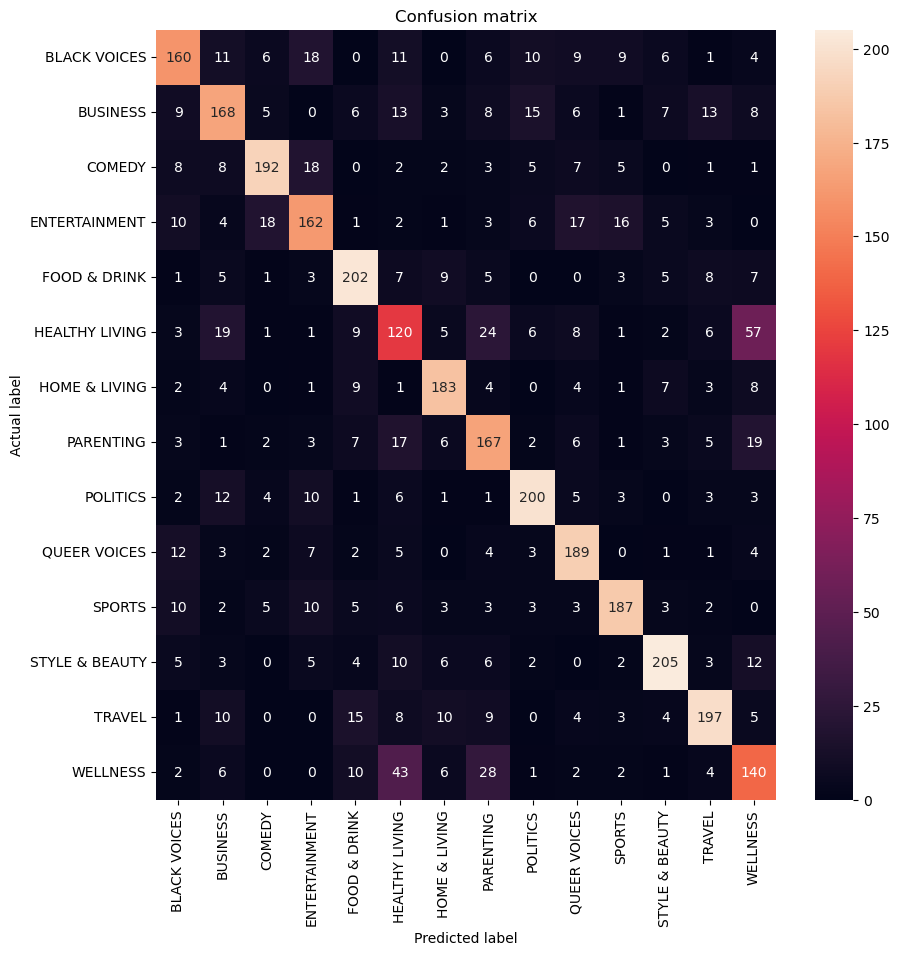

In [13]:
from sklearn.neural_network import MLPClassifier

def neural_network(X_train, X_test,y_train,y_test, mdf):
    NN = MLPClassifier(solver = 'adam', hidden_layer_sizes=(150,), activation='relu', alpha=0.0001, learning_rate='constant', max_iter=200, batch_size='auto')
    NN.fit(X_train, y_train)
    y_pred = NN.predict(X_test)
    mdf.loc['nn'] = [f1_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)]
    print(mdf)
    confused_matrix(y_test, y_pred, NN.classes_)

neural_network(X_train, X_test,y_train,y_test, metrics_dataframe)

### Trecho para exibição do resultados com cada algoritmo

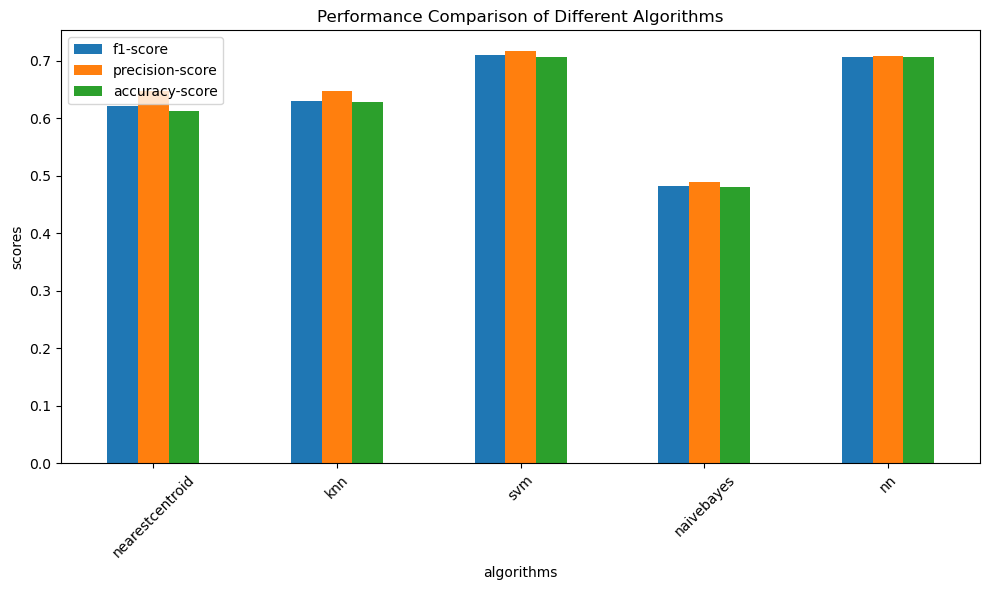

In [16]:

# Plotting
ax = metrics_dataframe.plot(kind='bar', figsize=(10, 6))

# Add labels and title
ax.set_xlabel('algorithms')
ax.set_ylabel('scores')
ax.set_title('Performance Comparison of Different Algorithms')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()